In [2]:
import numpy as np
import cv2
import misc
from RL_networks import Stand_alone_net
import pickle

import importlib
importlib.reload(misc)

In [4]:

from __future__ import division, print_function, absolute_import

# PyTorch libraries and modules
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn as nn
from mnist import MNIST

fmnist = torchvision.datasets.FashionMNIST('/home/orram/Documents/datasets/FMNIST/', download = True)
#images, labels = mnist.load_training()

# Training Parameters
learning_rate = 0.001
num_steps = 1000
batch_size = 128

validation_index=-5000

# Network Parameters
size=None
padding_size=(128,128)
# num_input = padding_size[0]*padding_size[1] # MNIST data input (img shape: 28*28)
num_classes = None 
# dropout = 0.25 # Dropout, probability to drop a unit

import matplotlib.pyplot as plt
%matplotlib notebook
import SYCLOP_env as syc



Extracting /home/orram/Documents/datasets/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/orram/Documents/datasets/FMNIST/FashionMNIST/raw


Extracting /home/orram/Documents/datasets/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/orram/Documents/datasets/FMNIST/FashionMNIST/raw


Extracting /home/orram/Documents/datasets/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/orram/Documents/datasets/FMNIST/FashionMNIST/raw



Extracting /home/orram/Documents/datasets/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/orram/Documents/datasets/FMNIST/FashionMNIST/raw
Processing...
Done!





/home/orram/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
images, labels = fmnist.data, fmnist.targets

In [6]:
#Define function for low resolution lens on syclop
def bad_res101(img,res):
    sh=np.shape(img)
    dwnsmp=cv2.resize(img,res, interpolation = cv2.INTER_CUBIC)
    upsmp = cv2.resize(dwnsmp,sh, interpolation = cv2.INTER_CUBIC)
    return upsmp

<IPython.core.display.Javascript object>


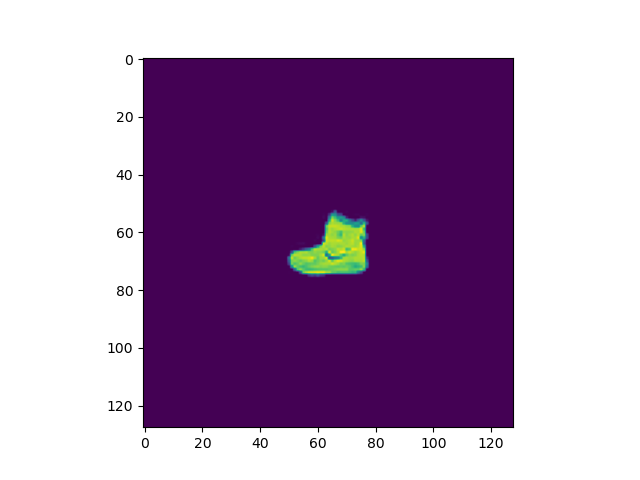

In [7]:
plt.figure()
plt.imshow(misc.build_mnist_padded(1./256*np.reshape(images[0],[1,28,28])))

In [8]:
img=misc.build_mnist_padded(1./256*np.reshape(images[0],[1,28,28]))

In [9]:
scene = syc.Scene(image_matrix=img)
sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])

In [10]:
q_sequence = np.array([[agent.max_q[0]//2, qq ] for qq in np.arange(agent.max_q[1]//2-10,agent.max_q[1]//2+10,4)])
q_sequence += np.array([[pp, 0] for pp in [] + list(np.linspace(-5,5,3,dtype = int)) + list(-np.linspace(0,5,2,dtype = int))])
#q_sequence = np.array(q_sequence)

In [11]:
q_sequence

array([[31, 26],
       [36, 30],
       [41, 34],
       [36, 38],
       [31, 42]])

In [12]:
sensor.hp.resolution_fun = lambda x: bad_res101(x,(28,28))
imim=[]
dimim=[]
agent.set_manual_trajectory(manual_q_sequence=q_sequence)
for t in range(70):
    agent.manual_act()
    sensor.update(scene, agent)
    imim.append(sensor.central_frame_view)
    dimim.append(sensor.central_dvs_view)
    

<IPython.core.display.Javascript object>


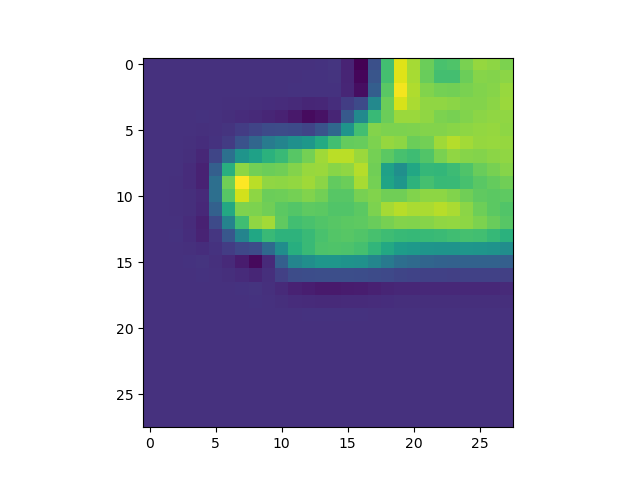

<IPython.core.display.Javascript object>


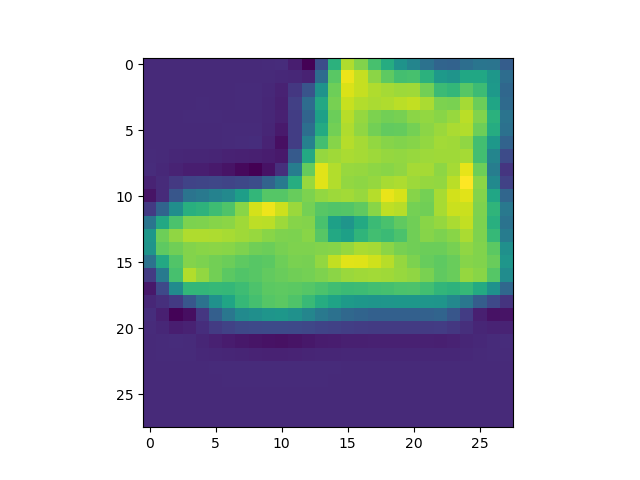

<IPython.core.display.Javascript object>


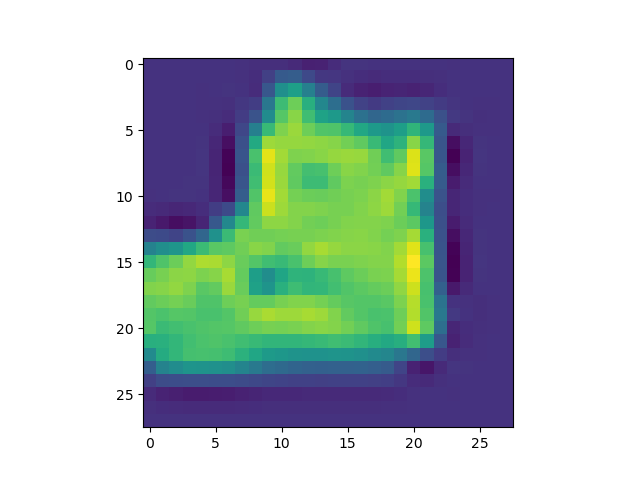

<IPython.core.display.Javascript object>


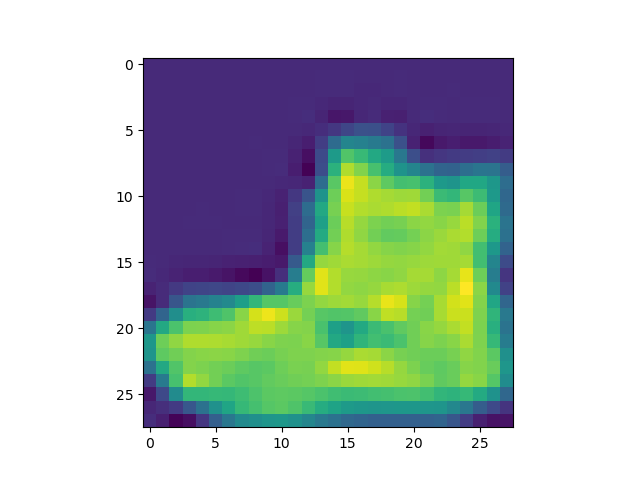

<IPython.core.display.Javascript object>


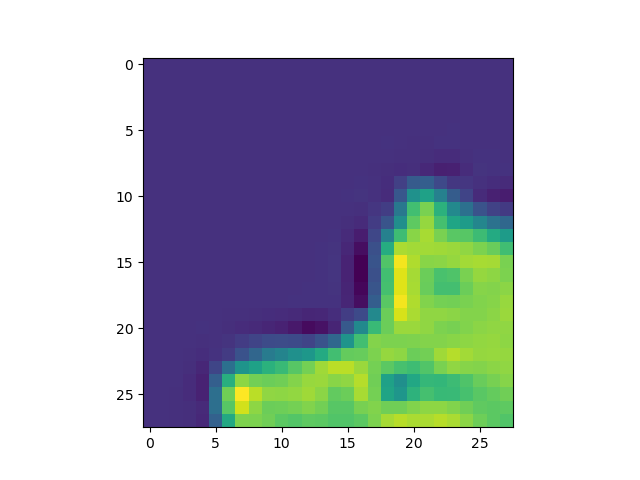

<IPython.core.display.Javascript object>


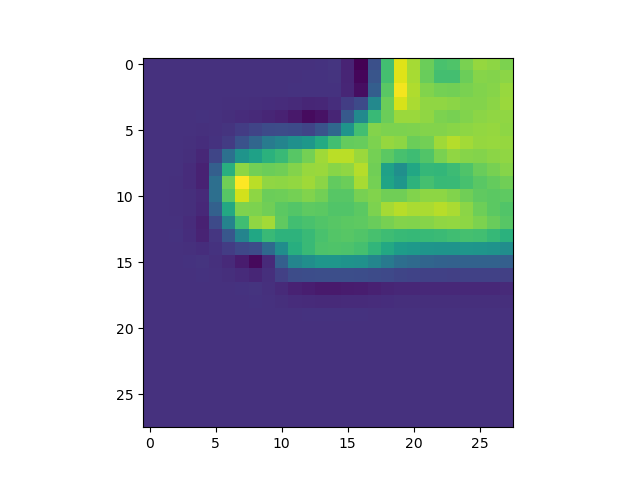

<IPython.core.display.Javascript object>


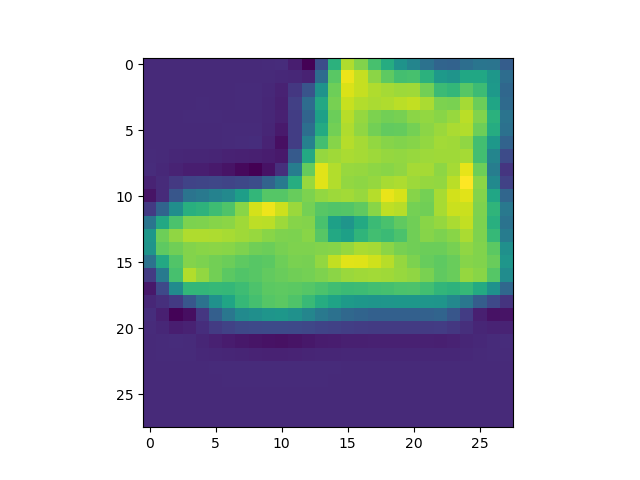

<IPython.core.display.Javascript object>


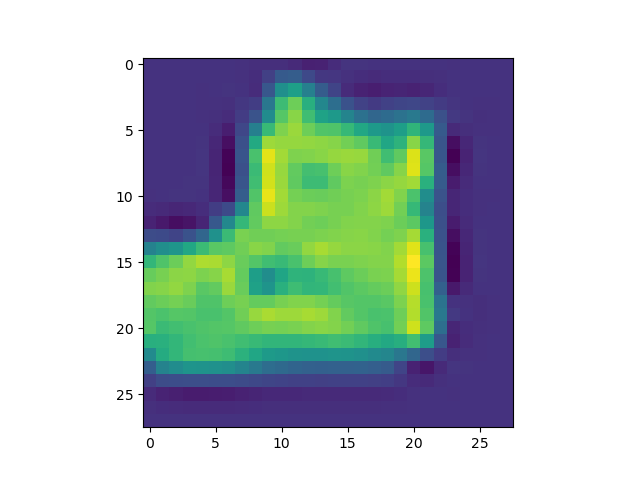

<IPython.core.display.Javascript object>


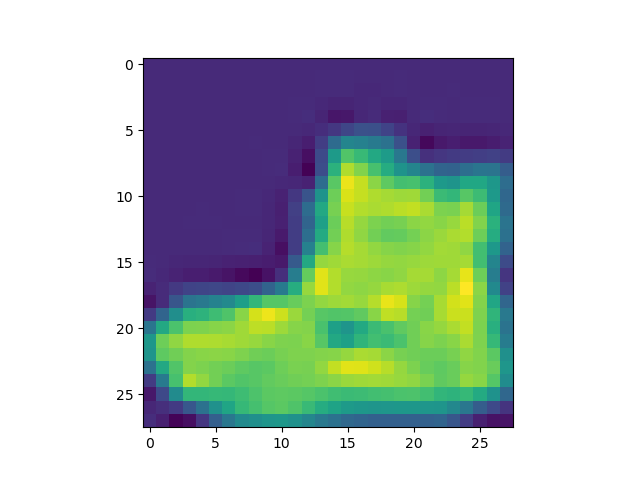

<IPython.core.display.Javascript object>


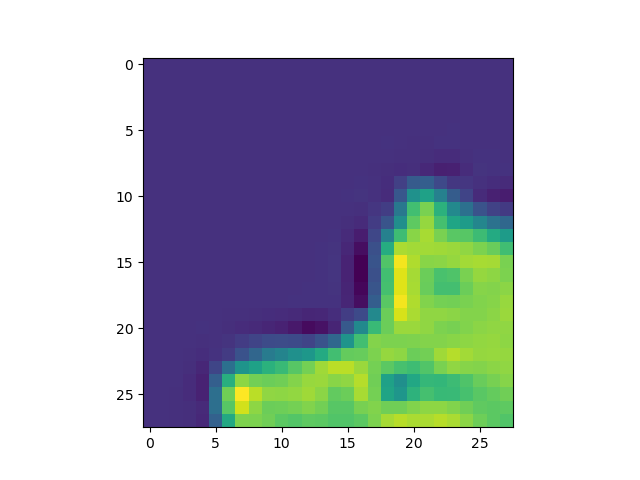

<IPython.core.display.Javascript object>


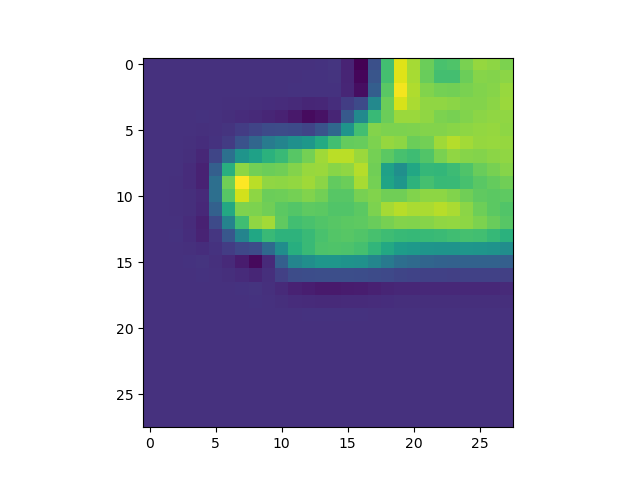

<IPython.core.display.Javascript object>


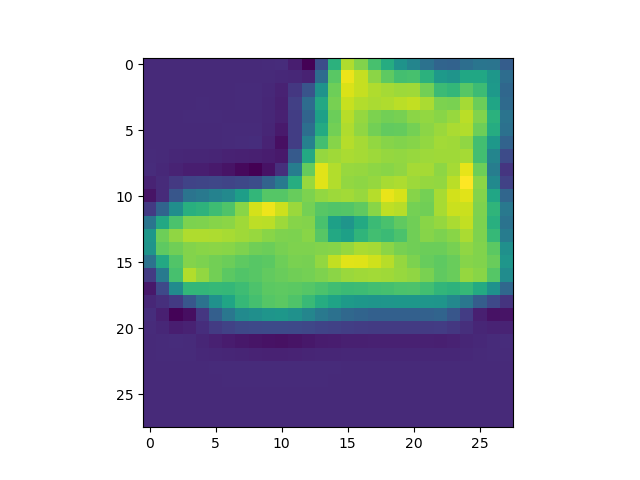

<IPython.core.display.Javascript object>


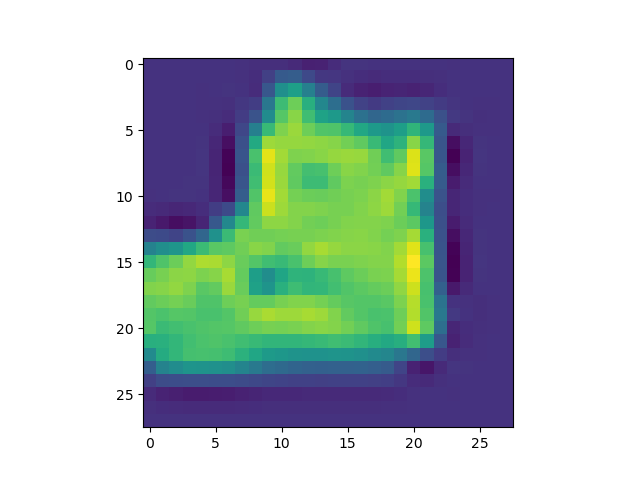

<IPython.core.display.Javascript object>


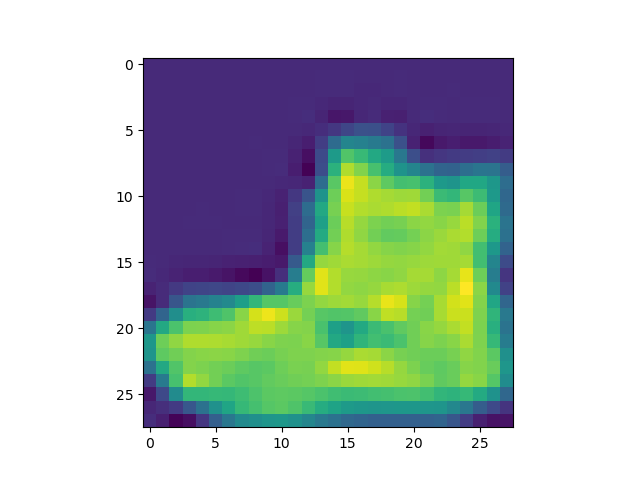

<IPython.core.display.Javascript object>


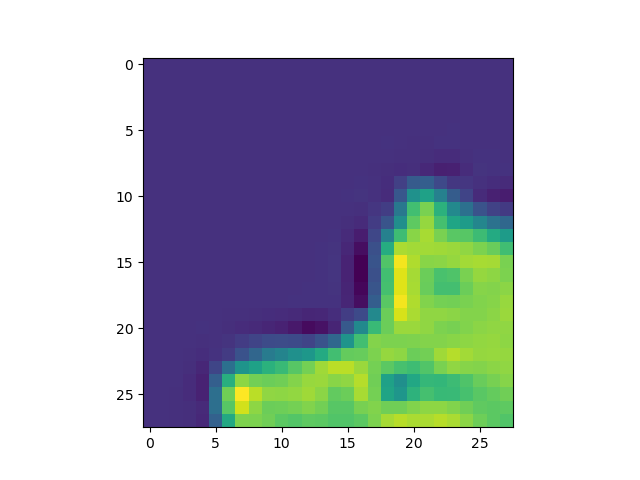

<IPython.core.display.Javascript object>


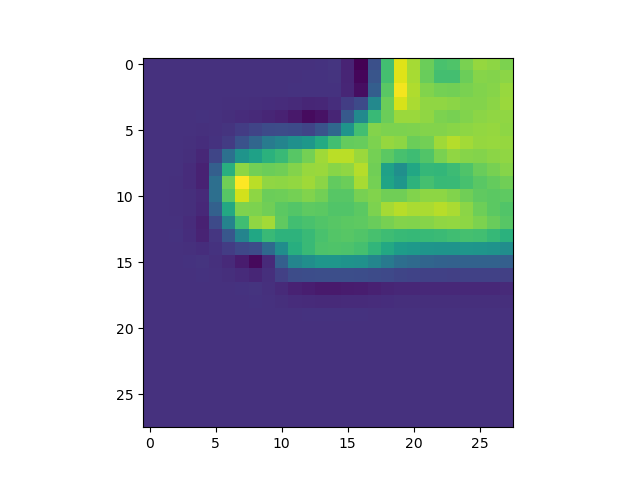

<IPython.core.display.Javascript object>


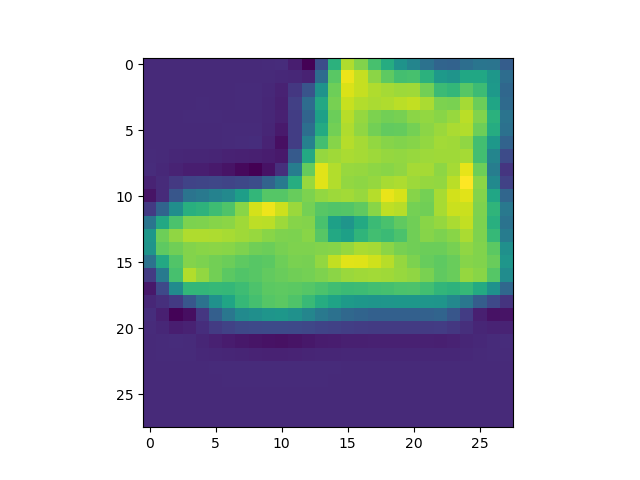

<IPython.core.display.Javascript object>


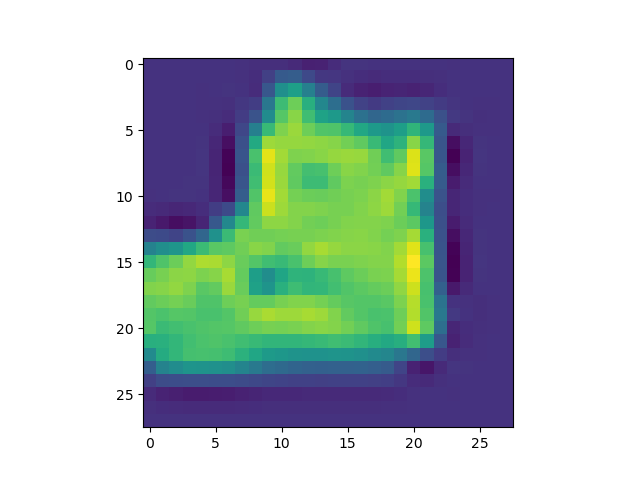

<IPython.core.display.Javascript object>


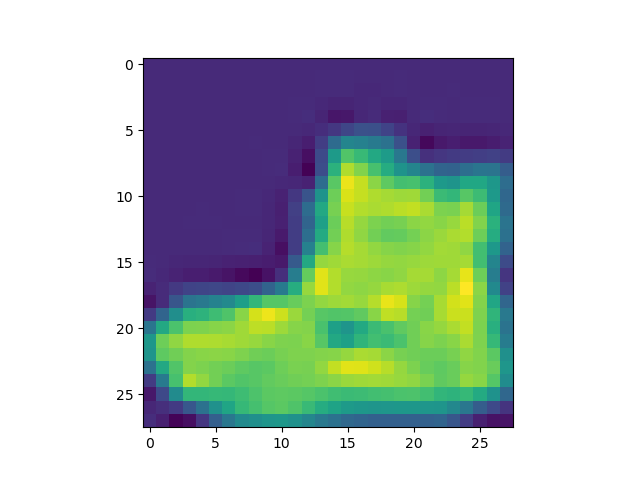

<ipython-input-13-68a586296195>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


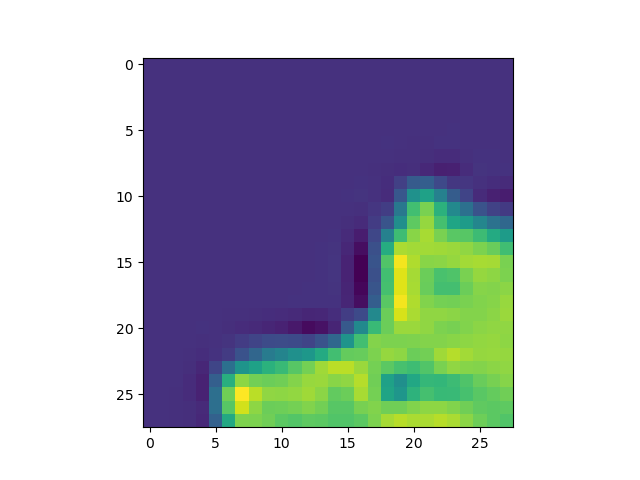

In [13]:
for i in range(20):
    plt.figure()
    plt.imshow(imim[i])

### Create a Dataset from the Syclops visual inputs
We are starting with a simple time series where the syclop starts from the same starting point, at the middle of the img on the x axis and the middle - 10 pixles on the y axis - (middle_point, middle_point - 10)
<br> Each time step the syclop will move one pixle up on the y axis, to a final point at (middle_point, middle_point + 10) and make a circular movement in the x direction.
<br> 

In [14]:
def create_dataset(images, labels, res, sample = 5):
    count = 0
    ts_images = []
    dvs_images = []
    count = 0
    #create subplot to hold examples from the dataset
    fig, ax = plt.subplots(2,5)
    i = 0 #indexises for the subplot for image and for syclop vision
    for img in images:
        orig_img = np.reshape(img,[28,28])
        #Set the padded image
        img=misc.build_mnist_padded(1./256*np.reshape(img,[1,28,28]))
        
        if count < 5:
            ax[0,i].imshow(orig_img) 
            plt.title(labels[count])
        #Set the sensor and the agent
        scene = syc.Scene(image_matrix=img)
        sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
        agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])
        #Setting the coordinates to visit
        q_sequence = np.array([[agent.max_q[0]//2, qq ] for qq in np.arange(agent.max_q[1]//2-10,agent.max_q[1]//2+10,4)])
        q_sequence += np.array([[pp, 0] for pp in [] + list(np.linspace(-5,5,3,dtype = int)) + list(-np.linspace(0,5,2,dtype = int))])
        #Setting the resolution function - starting with the regular resolution
        sensor.hp.resolution_fun = lambda x: bad_res101(x,(res,res))
        #Create empty lists to store the syclops outputs
        imim=[]
        dimim=[]
        agent.set_manual_trajectory(manual_q_sequence=q_sequence)
        #Run Syclop for 20 time steps
        for t in range(5):
            agent.manual_act()
            sensor.update(scene, agent)
            imim.append(sensor.central_frame_view)
            dimim.append(sensor.central_dvs_view)
        #Create a unified matrix from the list
        if count < 5:
            ax[1,i].imshow(imim[-3]) 
            plt.title(labels[count])
            i+=1

        imim = np.array(imim)
        dimim = np.array(dimim)
        #Add current proccessed image to lists
        ts_images.append(imim)
        dvs_images.append(dimim)
        count += 1
        


    ts_train = ts_images[:55_000]
    train_labels = labels[:55_000]
    ts_val = ts_images[55_000:]
    val_labels = labels[55_000:]

    dvs_train = dvs_images[:55_000]
    dvs_val = dvs_images[55_000:]
    
    class mnist_dataset(Dataset):
        def __init__(self, data, labels, transform = None):

            self.data = data
            self.labels = labels

            self.transform = transform
        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            '''
            args idx (int) :  index

            returns: tuple(data, label)
            '''
            data = self.data[idx]
            label = self.labels[idx]

            if self.transform:
                data = self.transform(data)
                return data, label
            else:
                return data, label

        def dataset(self):
            return self.data
        def labels(self):
            return self.labels



    train_dataset = mnist_dataset(dvs_train, train_labels)
    test_dataset = mnist_dataset(dvs_val, val_labels)
    batch = 64
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch, shuffle = True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch, shuffle = True)

    
    return train_dataloader, test_dataloader



<IPython.core.display.Javascript object>


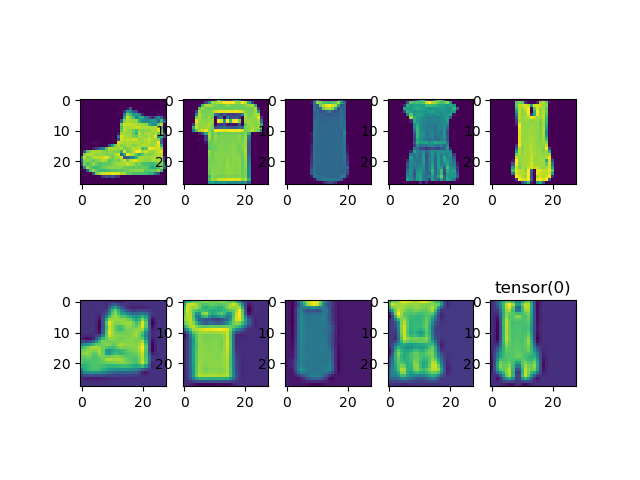

In [24]:
train_dataloader, test_dataloader = create_dataset(images, labels,res = 28)

In [25]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(5,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        
        self.fc1 = nn.Linear(8*8*16,64)
        self.fc2 = nn.Linear(64,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, img):
        
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        #print(img.shape)
        img = img.view(img.shape[0],8*8*16)
        img = self.relu(self.fc1(img))
        img = self.fc2(img)
        
        return img

In [26]:
class CNN_one_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        
        self.fc1 = nn.Linear(8*8*16,64)
        self.fc2 = nn.Linear(64,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, img):
        img = img[:,2,:,:]
        img = img.unsqueeze(1)
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        #print(img.shape)
        img = img.view(img.shape[0],8*8*16)
        img = self.relu(self.fc1(img))
        img = self.fc2(img)
        
        return img

In [27]:
def train(train_dataloader, test_dataloader, net, epochs = 10):

    lr = 3e-3
    #net = CNN().double()
    optimizer = Adam(net.parameters(), lr = lr)
    loss_func = nn.CrossEntropyLoss()

    train_loss = []
    test_loss = []
    test_accur = []
    for epoch in range(epochs):

        batch_loss = []
        for batch_idx, (data,targets) in enumerate(train_dataloader):
            #print(batch_idx, data.shape, targets.shape)
            if net.__class__.__name__ == 'RNN_Net':
                data = data.unsqueeze(2)
            optimizer.zero_grad()
            output = net(data.double())
            loss = loss_func(output, targets)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())


        train_loss.append(np.mean(batch_loss))

        if epoch%1 == 0:
            correct = 0
            test_batch_loss = []
            test_accuracy = []
            for batch_idx, (test_data,test_targets) in enumerate(test_dataloader):
                #print(batch_idx, data.shape, targets.shape)
                if net.__class__.__name__ == 'RNN_Net':
                    test_data = test_data.unsqueeze(2)
                test_output = net(test_data)
                loss = loss_func(test_output, test_targets)
                test_batch_loss.append(loss.item())
                test_pred = test_output.data.max(1, keepdim = True)[1]
                correct = test_pred.eq(test_targets.data.view_as(test_pred)).sum()
                test_accuracy.append(100.*correct/len(test_targets))
            print('Net',net.__class__.__name__,'Epoch : ',epoch+1, '\t', 'loss :', loss.item(), 'accuracy :',np.mean(test_accuracy) )
            test_loss.append(np.mean(test_batch_loss))
            test_accur.append(np.mean(test_accuracy))
    
    return train_loss, test_loss, test_accur

In [28]:
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = CNN_one_layer().double(), epochs = 10)

Net CNN_one_layer Epoch :  1 	 loss : 0.03058804370908067 accuracy : 87.73734
Net CNN_one_layer Epoch :  2 	 loss : 0.3337633160173269 accuracy : 87.44067
Net CNN_one_layer Epoch :  3 	 loss : 0.12134344440850796 accuracy : 88.587814
Net CNN_one_layer Epoch :  4 	 loss : 0.14365480520513713 accuracy : 88.548256
Net CNN_one_layer Epoch :  5 	 loss : 0.4690368950079323 accuracy : 89.37895
Net CNN_one_layer Epoch :  6 	 loss : 0.06916207734259924 accuracy : 88.94383
Net CNN_one_layer Epoch :  7 	 loss : 0.006761695493167985 accuracy : 90.1701
Net CNN_one_layer Epoch :  8 	 loss : 0.0734515350617233 accuracy : 89.794304
Net CNN_one_layer Epoch :  9 	 loss : 0.06581936623056595 accuracy : 89.754745
Net CNN_one_layer Epoch :  10 	 loss : 0.06281489821256121 accuracy : 89.29984


In [58]:
import torch
torch.manual_seed(0)
torch.randint(3, 10, (3,))

tensor([7, 6, 3])

In [ ]:
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = CNN().double(), epochs = 10)

### Regular conv net with regular data stacked works as well with more then 99% accuracy - let's push it into an RNN and see that we replecate the resilts before moving to lower resolutions. 

In [18]:
class RNN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        self.gru = nn.GRU(8*8*16,100)
        self.fc1 = nn.Linear(100,10)
        #self.fc2 = nn.Linear(6,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, data):
        hn = torch.zeros([1,data.shape[0],100]).double()
        #print(data.shape)
        for i in range(data.shape[1]):
            img = data[:,i,:,:,:]
            #print(img.shape)
            #plt.figure()
            #plt.imshow(img[0][0])
            img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
            img = self.pool(self.relu(self.bn2(self.conv2(img))))
            img = self.relu(self.bn3(self.conv3(img)))        
            img = img.view(img.shape[0],8*8*16)
            out, hn = self.gru(img.unsqueeze(0),hn)
            #print(out.shape)
        output = self.fc1(out[0, :, :])
        
        
        return output

In [19]:
class RNN_Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,4,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        self.gru = nn.GRU(8*8*16,100, batch_first=True)
        self.fc1 = nn.Linear(100,10)
        #self.fc2 = nn.Linear(6,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, data):
        batch_size, timesteps, C, H, W = data.size()
        img = datax.view(batch_size * timesteps, C, H, W)
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        print(img.shape)
        img = img.view(img.shape[0],img.shape[1],8*8*16)
        out, hn = self.gru(img)
        output = self.fc1(hn.squeeze(0))
        
        
        return output

In [38]:
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = RNN_Net().double(), epochs = 10)

Epoch :  1 	 loss : 0.004265323125684652 accuracy : 98.912186
Epoch :  2 	 loss : 0.020991770685789404 accuracy : 99.03085
Epoch :  3 	 loss : 0.5524997304981456 accuracy : 98.85285
Epoch :  4 	 loss : 0.09526686410688172 accuracy : 99.129745
Epoch :  5 	 loss : 0.00017887853745292805 accuracy : 98.75395
Epoch :  6 	 loss : 0.0010102674777342335 accuracy : 99.01108


### Mooving on to lower resolutions 

<IPython.core.display.Javascript object>


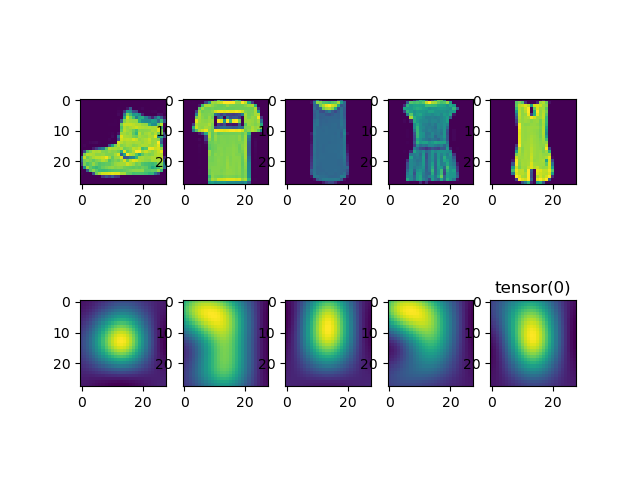

In [60]:
#Load the training data
train_dataloader, test_dataloader = create_dataset(images, labels,res = 5)

In [62]:
#Run the CNN over one image only
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = CNN_one_layer().double(), epochs = 4)

Net CNN_one_layer Epoch :  1 	 loss : 0.6928578578252791 accuracy : 66.0799
Net CNN_one_layer Epoch :  2 	 loss : 0.8037868644434882 accuracy : 68.730225
Net CNN_one_layer Epoch :  3 	 loss : 0.7896571620328736 accuracy : 70.05538
Net CNN_one_layer Epoch :  4 	 loss : 0.7016944606646146 accuracy : 70.43117


In [63]:
#Run the CNN over the stacked images
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = CNN().double(), epochs = 4)

Net CNN Epoch :  1 	 loss : 1.2028912876690765 accuracy : 77.49209
Net CNN Epoch :  2 	 loss : 1.4378103566202989 accuracy : 79.529274
Net CNN Epoch :  3 	 loss : 0.3269476456033512 accuracy : 80.28085
Net CNN Epoch :  4 	 loss : 0.33019151748928116 accuracy : 79.60838


In [61]:
#Run the CNN+RNN over the stacked images
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = RNN_Net().double(), epochs = 4)

Net RNN_Net Epoch :  1 	 loss : 0.9989843465900519 accuracy : 78.65902
Net RNN_Net Epoch :  2 	 loss : 0.6347406449322527 accuracy : 79.885284
Net RNN_Net Epoch :  3 	 loss : 1.1014116614995084 accuracy : 80.49842
Net RNN_Net Epoch :  4 	 loss : 0.795792869557406 accuracy : 81.03244


<IPython.core.display.Javascript object>


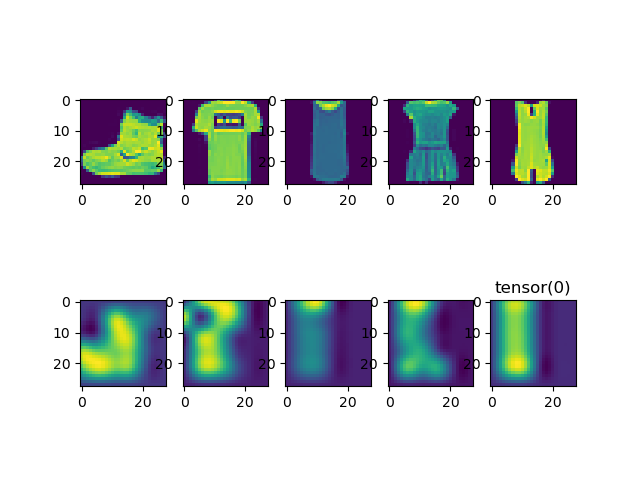

Net CNN_one_layer Epoch :  1 	 loss : 0.24524896002926683 accuracy : 73.8924
Net CNN_one_layer Epoch :  2 	 loss : 0.8696094473079894 accuracy : 75.35601
Net CNN_one_layer Epoch :  3 	 loss : 0.48223202342285715 accuracy : 76.008705
Net CNN_one_layer Epoch :  4 	 loss : 0.41827073876829596 accuracy : 76.5625
Net CNN Epoch :  1 	 loss : 1.1780623938032115 accuracy : 79.62817
Net CNN Epoch :  2 	 loss : 0.5024136518290743 accuracy : 80.28085
Net CNN Epoch :  3 	 loss : 0.38882848073885795 accuracy : 82.120255
Net CNN Epoch :  4 	 loss : 0.05037237180772224 accuracy : 82.8125
Net RNN_Net Epoch :  1 	 loss : 0.724348795058591 accuracy : 78.77769
Net RNN_Net Epoch :  2 	 loss : 0.5768786140860774 accuracy : 80.419304
Net RNN_Net Epoch :  3 	 loss : 0.6826560607647549 accuracy : 82.21915
Net RNN_Net Epoch :  4 	 loss : 0.9803164326590469 accuracy : 82.258705


<IPython.core.display.Javascript object>


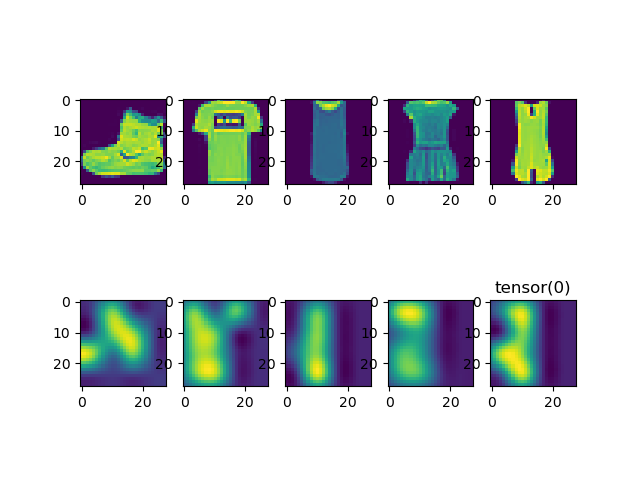

Net CNN_one_layer Epoch :  1 	 loss : 0.5236803167585016 accuracy : 74.60443
Net CNN_one_layer Epoch :  2 	 loss : 0.6599409197676415 accuracy : 75.59335
Net CNN_one_layer Epoch :  3 	 loss : 0.3839269117200969 accuracy : 77.0174
Net CNN_one_layer Epoch :  4 	 loss : 0.5593429393569854 accuracy : 77.076744
Net CNN Epoch :  1 	 loss : 0.55811222308581 accuracy : 80.57753
Net CNN Epoch :  2 	 loss : 0.694768529231144 accuracy : 81.408226
Net CNN Epoch :  3 	 loss : 0.8084376152894643 accuracy : 82.5356
Net CNN Epoch :  4 	 loss : 0.09395495939635563 accuracy : 83.74209
Net RNN_Net Epoch :  1 	 loss : 0.35944659411089463 accuracy : 81.56645
Net RNN_Net Epoch :  2 	 loss : 0.4904130529110988 accuracy : 82.69383
Net RNN_Net Epoch :  3 	 loss : 0.9393357887251917 accuracy : 83.03006
Net RNN_Net Epoch :  4 	 loss : 0.9091938561784665 accuracy : 83.52453


<IPython.core.display.Javascript object>


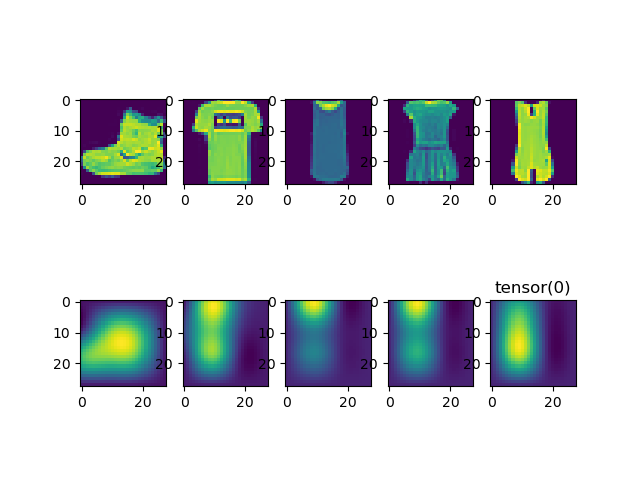

Net CNN_one_layer Epoch :  1 	 loss : 0.32869943409349267 accuracy : 66.77215
Net CNN_one_layer Epoch :  2 	 loss : 1.5348588818654778 accuracy : 68.98734
Net CNN_one_layer Epoch :  3 	 loss : 0.774649791159499 accuracy : 70.13449
Net CNN_one_layer Epoch :  4 	 loss : 1.14382796395983 accuracy : 69.481804
Net CNN Epoch :  1 	 loss : 0.665703588467355 accuracy : 77.41297
Net CNN Epoch :  2 	 loss : 0.5440004056874147 accuracy : 76.64162
Net CNN Epoch :  3 	 loss : 0.9397353216269239 accuracy : 78.89636
Net CNN Epoch :  4 	 loss : 0.21787571478856957 accuracy : 79.60838
Net RNN_Net Epoch :  1 	 loss : 0.2917544517275075 accuracy : 76.62183
Net RNN_Net Epoch :  2 	 loss : 0.3858397475251961 accuracy : 78.44145
Net RNN_Net Epoch :  3 	 loss : 0.4230530214159249 accuracy : 79.39082
Net RNN_Net Epoch :  4 	 loss : 0.5446635366042738 accuracy : 79.845726


<IPython.core.display.Javascript object>


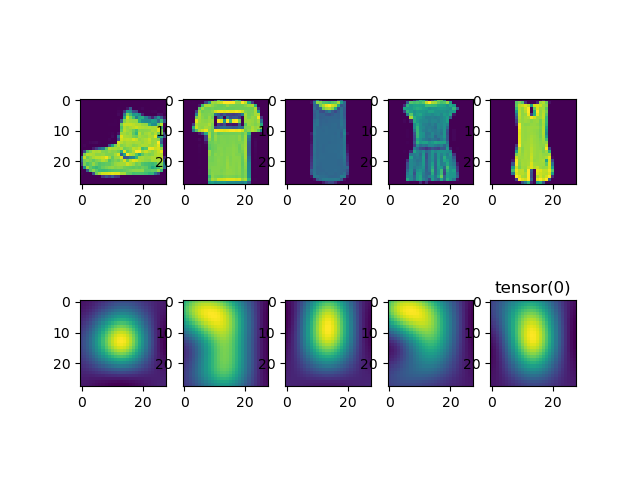

Net CNN_one_layer Epoch :  1 	 loss : 0.5977955476396323 accuracy : 67.662186
Net CNN_one_layer Epoch :  2 	 loss : 0.8722582610032619 accuracy : 68.908226
Net CNN_one_layer Epoch :  3 	 loss : 0.5185352150545115 accuracy : 70.17405
Net CNN_one_layer Epoch :  4 	 loss : 0.7897202661864704 accuracy : 70.53006
Net CNN Epoch :  1 	 loss : 0.6871613446278804 accuracy : 78.817245
Net CNN Epoch :  2 	 loss : 0.3894344981249866 accuracy : 79.46994
Net CNN Epoch :  3 	 loss : 0.5840444831999505 accuracy : 80.1424
Net CNN Epoch :  4 	 loss : 0.5596472695154769 accuracy : 81.01266
Net RNN_Net Epoch :  1 	 loss : 0.25111881524465207 accuracy : 78.5799
Net RNN_Net Epoch :  2 	 loss : 0.40378011793839913 accuracy : 80.53797
Net RNN_Net Epoch :  3 	 loss : 0.5086767837609913 accuracy : 80.63686
Net RNN_Net Epoch :  4 	 loss : 0.6030672169151516 accuracy : 80.9731


<IPython.core.display.Javascript object>


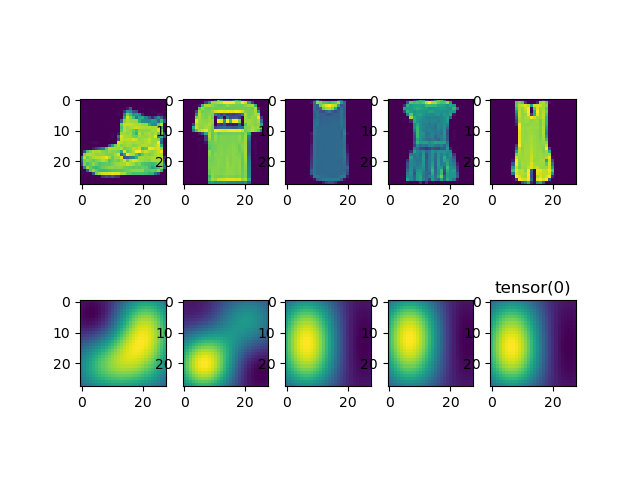

Net CNN_one_layer Epoch :  1 	 loss : 1.3985381267306227 accuracy : 49.564873
Net CNN_one_layer Epoch :  2 	 loss : 0.532595026664727 accuracy : 51.977848
Net CNN_one_layer Epoch :  3 	 loss : 1.1146035889244341 accuracy : 50.969147
Net CNN_one_layer Epoch :  4 	 loss : 1.3647271111448815 accuracy : 52.09652
Net CNN Epoch :  1 	 loss : 0.5864662815543095 accuracy : 69.28402
Net CNN Epoch :  2 	 loss : 0.5714644529473658 accuracy : 72.80459
Net CNN Epoch :  3 	 loss : 0.7456044489723346 accuracy : 72.58703
Net CNN Epoch :  4 	 loss : 0.8559903685849852 accuracy : 73.33861
Net RNN_Net Epoch :  1 	 loss : 0.5733396188342164 accuracy : 70.0356
Net RNN_Net Epoch :  2 	 loss : 0.9783048403671092 accuracy : 70.27294
Net RNN_Net Epoch :  3 	 loss : 0.4052083176353711 accuracy : 73.12105
Net RNN_Net Epoch :  4 	 loss : 0.799801572452307 accuracy : 72.883705


<IPython.core.display.Javascript object>


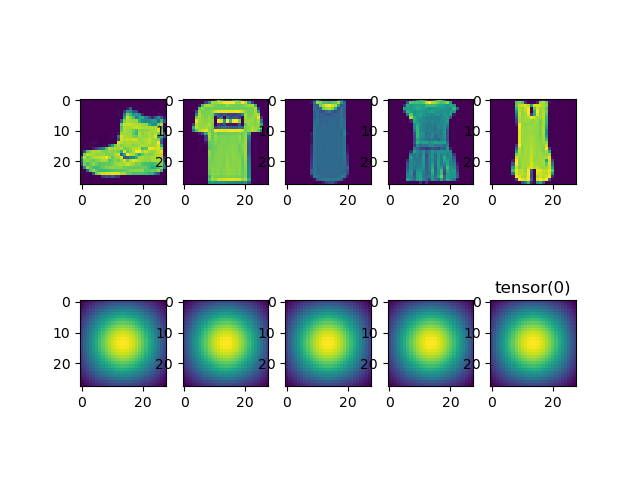

Net CNN_one_layer Epoch :  1 	 loss : 2.123816062349889 accuracy : 39.873417
Net CNN_one_layer Epoch :  2 	 loss : 1.3311266620033204 accuracy : 41.11946
Net CNN_one_layer Epoch :  3 	 loss : 1.6376141160788622 accuracy : 41.00079
Net CNN_one_layer Epoch :  4 	 loss : 1.7281362389248542 accuracy : 40.170094
Net CNN Epoch :  1 	 loss : 1.3825559084166614 accuracy : 58.48497
Net CNN Epoch :  2 	 loss : 1.370873727155432 accuracy : 60.126583
Net CNN Epoch :  3 	 loss : 0.6096489202265196 accuracy : 62.143986
Net CNN Epoch :  4 	 loss : 1.0432435467121466 accuracy : 62.163765
Net RNN_Net Epoch :  1 	 loss : 1.0124029387225233 accuracy : 61.649525
Net RNN_Net Epoch :  2 	 loss : 1.5506530313997524 accuracy : 62.38133
Net RNN_Net Epoch :  3 	 loss : 0.8646393283082722 accuracy : 64.73497
Net RNN_Net Epoch :  4 	 loss : 0.5793972623245345 accuracy : 64.893196


<IPython.core.display.Javascript object>


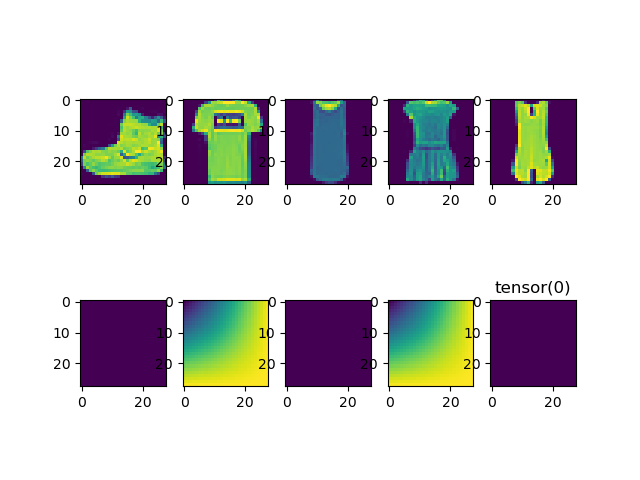

Net CNN_one_layer Epoch :  1 	 loss : 1.6263044781132643 accuracy : 32.93117
Net CNN_one_layer Epoch :  2 	 loss : 1.2149338054607604 accuracy : 34.058544
Net CNN_one_layer Epoch :  3 	 loss : 1.4817859600537329 accuracy : 35.363926
Net CNN_one_layer Epoch :  4 	 loss : 1.3994747673590098 accuracy : 35.46282
Net CNN Epoch :  1 	 loss : 1.202829873077751 accuracy : 49.52532
Net CNN Epoch :  2 	 loss : 1.1270198174055135 accuracy : 49.821995
Net CNN Epoch :  3 	 loss : 1.503716456921174 accuracy : 50.53402
Net CNN Epoch :  4 	 loss : 1.3320156027721874 accuracy : 51.0087
Net RNN_Net Epoch :  1 	 loss : 1.610787578467098 accuracy : 52.45253
Net RNN_Net Epoch :  2 	 loss : 1.764589068433766 accuracy : 49.46598
Net RNN_Net Epoch :  3 	 loss : 1.1696313742857807 accuracy : 56.26978
Net RNN_Net Epoch :  4 	 loss : 1.4606590222622151 accuracy : 54.766613


In [64]:
res_list = [10,8,6,5,4,3,2]
cnn_one_image = []
cnn_lasagna = []
cnn_rnn = []
cnn_one_image_train_loss = []
cnn_lasagna_train_loss = []
cnn_rnn_train_loss = []
for res in res_list:
    #Load the training data
    train_dataloader, test_dataloader = create_dataset(images, labels,res = res)
    #Run the CNN over one image only
    cnn1_train_loss, cnn1_test_loss, cnn1_test_accur =  train(train_dataloader, test_dataloader,net = CNN_one_layer().double(), epochs = 4)
    cnn_one_image.append(cnn1_test_accur[-1])
    cnn_one_image_train_loss.append(cnn1_train_loss[-1])
    #Run the CNN over the stacked images
    cnn_train_loss, cnn_test_loss, cnn_test_accur =  train(train_dataloader, test_dataloader,net = CNN().double(), epochs = 4)
    cnn_lasagna.append(cnn_test_accur[-1])
    cnn_lasagna_train_loss.append(cnn_train_loss[-1])
    #Run the CNN+RNN over the stacked images
    rnn_train_loss, rnn_test_loss, rnn_test_accur =  train(train_dataloader, test_dataloader,net = RNN_Net().double(), epochs = 4)
    cnn_rnn.append(rnn_test_accur[-1])
    cnn_rnn_train_loss.append(rnn_train_loss[-1])

<IPython.core.display.Javascript object>


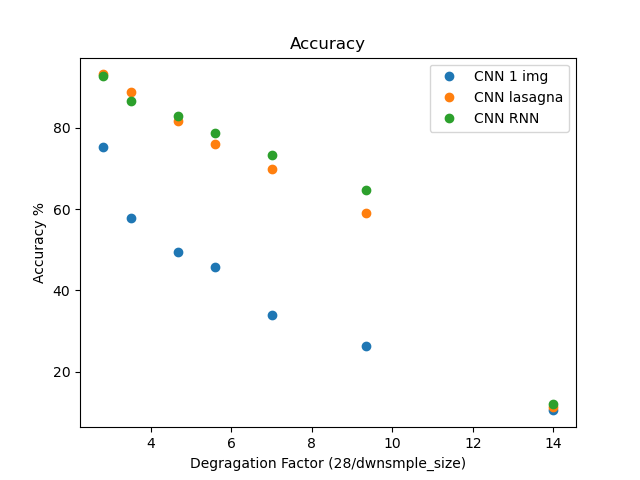

<IPython.core.display.Javascript object>


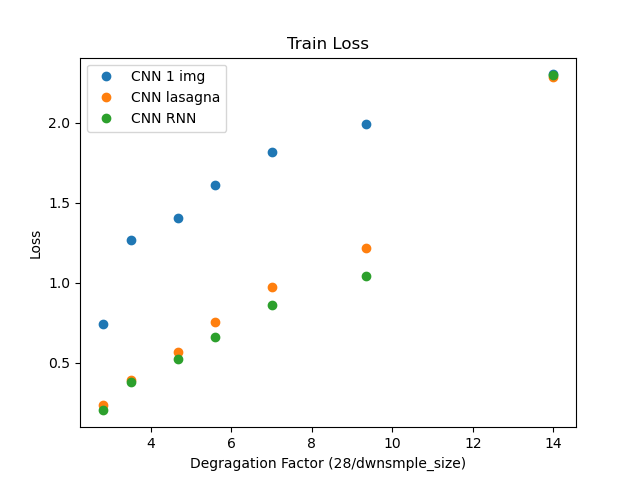

In [19]:
plt.figure()
plt.plot(28/np.array(res_list),cnn_one_image,'o', label = 'CNN 1 img')
plt.plot(28/np.array(res_list),cnn_lasagna,'o', label = 'CNN lasagna')
plt.plot(28/np.array(res_list),cnn_rnn,'o', label = 'CNN RNN')
plt.title('Accuracy')
plt.xlabel('Degragation Factor (28/dwnsmple_size)')
plt.ylabel('Accuracy %')
plt.legend()

plt.figure()
plt.plot(28/np.array(res_list),cnn_one_image_train_loss,'o', label = 'CNN 1 img')
plt.plot(28/np.array(res_list),cnn_lasagna_train_loss, 'o',label = 'CNN lasagna')
plt.plot(28/np.array(res_list),cnn_rnn_train_loss, 'o',label = 'CNN RNN')
plt.title('Train Loss')
plt.xlabel('Degragation Factor (28/dwnsmple_size)')
plt.ylabel('Loss')
plt.legend()

<IPython.core.display.Javascript object>


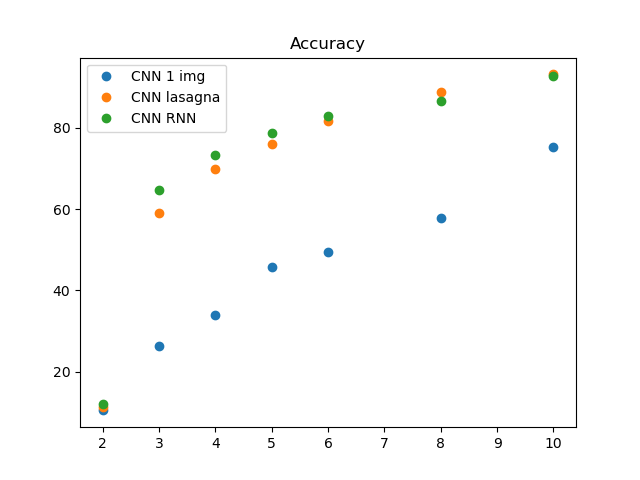

<IPython.core.display.Javascript object>


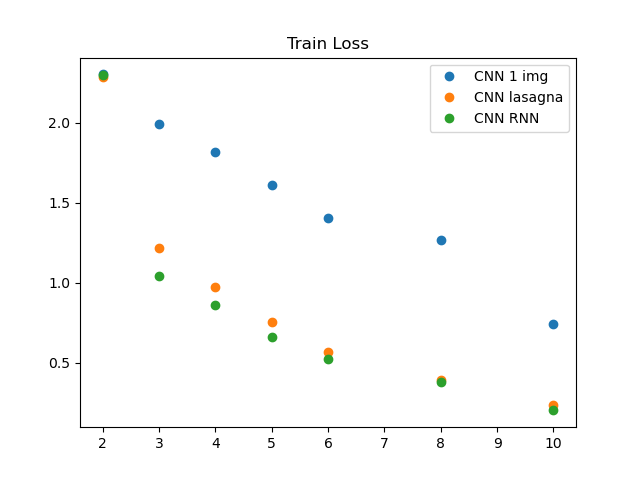

In [17]:
plt.figure()
plt.plot(np.array(res_list),cnn_one_image,'o', label = 'CNN 1 img')
plt.plot(np.array(res_list),cnn_lasagna,'o', label = 'CNN lasagna')
plt.plot(np.array(res_list),cnn_rnn,'o', label = 'CNN RNN')
plt.title('Accuracy')
plt.legend()

plt.figure()
plt.plot(np.array(res_list),cnn_one_image_train_loss,'o', label = 'CNN 1 img')
plt.plot(np.array(res_list),cnn_lasagna_train_loss, 'o',label = 'CNN lasagna')
plt.plot(np.array(res_list),cnn_rnn_train_loss, 'o',label = 'CNN RNN')
plt.title('Train Loss')
plt.legend()